In [ ]:
import torch
import numpy as np

## 3.1 Автоматическое дифференцирование в `torch`

3.1.1 Воспользовавшись классами `Neuron` и `SquaredLoss` из задачи 2.4.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать стохастический градиетный спуск.

In [ ]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [ ]:
class SquaredLoss:
    def forward(self, y_pred, y_true):
        self.loss = (y_pred - y_true) ** 2
        return self.loss

    def backward(self):
        self.loss.backward()

In [ ]:
class Neuron:
    def __init__(self, n_inputs):
        self.weights = torch.randn(n_inputs, requires_grad=True)
        self.bias = torch.randn(1, requires_grad=True)

    def forward(self, inputs):
        return torch.dot(self.weights, inputs) + self.bias

    def backward(self):
        self.dweights = self.weights.grad # df/dW
        self.dbias = self.bias.grad # df/db

In [ ]:
import random

n_inputs = X.shape[-1] # <размерность элемента выборки >
lr = 0.001 #  скорость обучения
n_epoch = 100 #  количество эпох

neuron = Neuron(n_inputs)

loss = SquaredLoss()


for epoch in range(n_epoch):
    losses = []
    for x_example, y_example in zip(X, y):
        y_pred = neuron.forward(x_example)
        loss.forward(y_pred, y_example)
        losses.append(loss.loss.item())
        # backprop
        loss.backward()

        neuron.backward()
        # градиентный спуск
        with torch.no_grad():
            neuron.weights -= lr * neuron.weights.grad
            neuron.bias -= lr * neuron.dbias



        neuron.weights.grad.zero_()
        neuron.bias.grad.zero_()


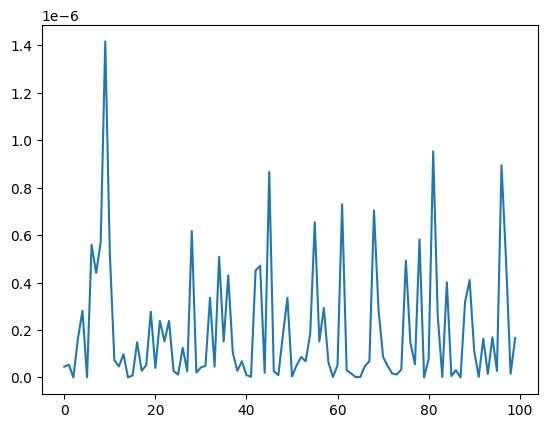

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(losses)

In [ ]:
coef

array([21.36485942, 44.6918724 , 91.41711946,  5.16579237])

In [ ]:
neuron.weights

tensor([21.3649, 44.6917, 91.4166,  5.1657], requires_grad=True)

3.1.2 Воспользовавшись классами `Linear` и `MSELoss` из задачи 2.1.4 и 2.3.1, `ReLU` из 2.2.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать пакетный градиентный спуск. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
class MSELoss:
    def forward(self, y_pred, y_true):
        self.loss = ((y_pred.view(-1, 1) - y_true.view(-1, 1)) ** 2).mean()
        return self.loss

    def backward(self):
        self.loss.backward()

In [ ]:
class ReLU:
    def forward(self, inputs):
        self.output = inputs.clip(min=0)
        return self.output

In [ ]:
class Linear:
    def __init__(self, n_features, n_neurons):
        # <создать атрибуты объекта weights и biases>
        self.weights = torch.randn(n_features, n_neurons, requires_grad=True)
        self.bias = torch.randn(n_neurons, requires_grad=True)

    def forward(self, inputs):
        return torch.matmul(inputs, self.weights) + self.bias # <реализовать логику слоя>

    def backward(self):
        self.dweights = self.weights.grad # df/dW
        self.dbias = self.bias.grad # df/db

In [ ]:
y[:10]

tensor([[0.0478],
        [0.0712],
        [0.1462],
        [0.2366],
        [0.2776],
        [0.3828],
        [0.4642],
        [0.4299],
        [0.4998],
        [0.6206]])

In [ ]:
# создание компонентов сети
fc1 = Linear(X.shape[1], 5)
relu1 = ReLU()
fc2 = Linear(5, 3)
loss = MSELoss()
relu2 = ReLU()
fc3 = Linear(3, 1)

lr = 0.1
n_epoch = 1000

ys = []
losses = []
for epoch in range(n_epoch):

    y_pred = fc3.forward(relu2.forward(fc2.forward(relu1.forward(fc1.forward(X)))))

    data_loss = loss.forward(y_pred, y) # <прогон через функцию потерь>
    losses.append(data_loss.item())
    if epoch % 2 == 0:
        ys.append(y_pred)

    # <backprop>
    # loss > fc2 > relu1 > fc1
    loss.backward()
    fc3.backward()
    fc2.backward()
    fc1.backward()

    # <шаг оптимизации для fc1>
    with torch.no_grad():
        fc1.weights -= lr * fc1.dweights
        fc1.bias -= lr * fc1.dbias

    # <шаг оптимизации для fc2>
    with torch.no_grad():
        fc2.weights -= lr * fc2.dweights
        fc2.bias -= lr * fc2.dbias

    with torch.no_grad():
       fc3.weights -= lr * fc3.dweights
       fc3.bias -= lr * fc3.dbias

    # <обнуляем градиент для fc1>
    fc1.weights.grad.zero_()
    fc1.bias.grad.zero_()

    # <обнуляем градиент для fc2>
    fc2.weights.grad.zero_()
    fc2.bias.grad.zero_()

    # <обнуляем градиент для fc3>
    fc3.weights.grad.zero_()
    fc3.bias.grad.zero_()

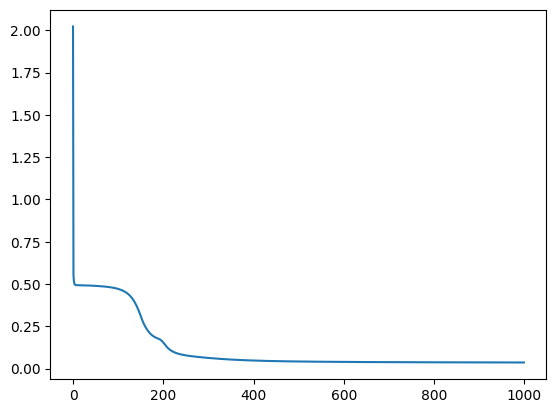

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses);

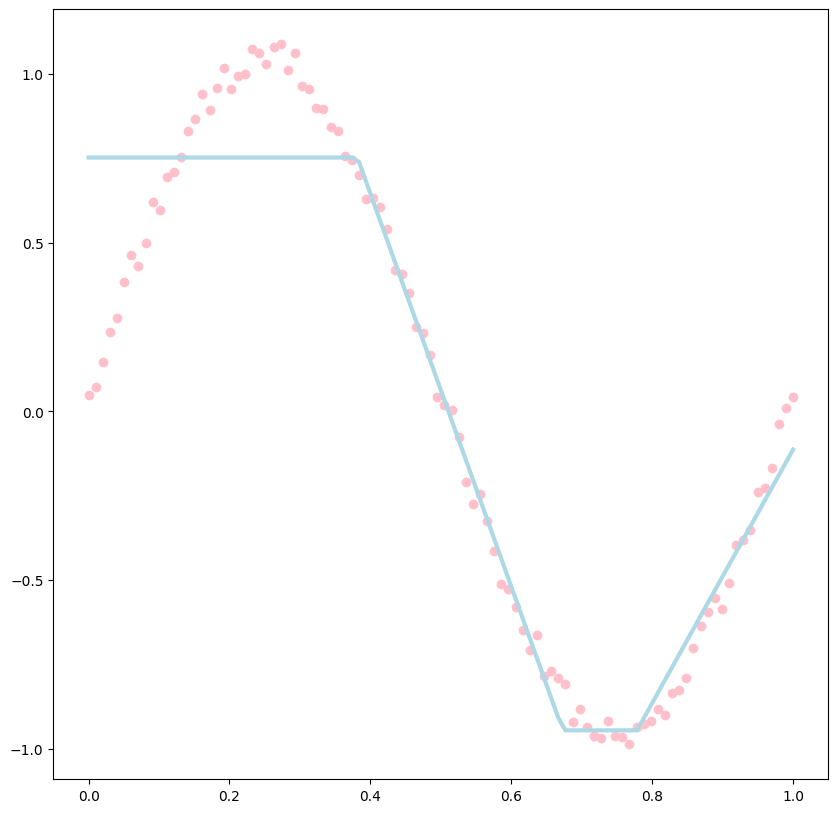

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.scatter(X.numpy(), y.numpy(), color = "pink")
axs.plot(X.numpy(), ys[-1].detach().numpy(), 'lightblue', lw=3)

## 3.2 Алгоритмы оптимизации в `torch.optim`

In [ ]:
import torch.optim as optim

3.2.1 Решить задачу 3.1.1, воспользовавшись оптимизатором `optim.SDG` для применения стохастического градиентого спуска

In [ ]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [ ]:
class SquaredLoss:
    def forward(self, y_pred, y_true):
        self.loss = ((y_pred - y_true) ** 2).mean()
        return self.loss

    def backward(self):
        self.loss.backward()

In [ ]:
class Neuron:
    def __init__(self, n_inputs):
        self.weights = torch.randn(n_inputs, requires_grad=True)
        self.bias = torch.randn(1, requires_grad=True)

    def forward(self, inputs):
        return torch.dot(self.weights, inputs) + self.bias

In [ ]:
import random

n_inputs = 4 # <размерность элемента выборки >
lr = 0.01 #  скорость обучения
n_epoch = 100 #  количество эпох

neuron = Neuron(n_inputs)
loss = SquaredLoss()

optimizer = torch.optim.SGD([neuron.weights, neuron.bias], lr=lr)

for epoch in range(n_epoch):
    losses = []
    for x_example, y_example in zip(X, y):

        y_pred = neuron.forward(x_example) # <прогон через нейрон>
        curr_loss = loss.forward(y_pred, y_example) # <прогон через функцию потерь>
        losses.append(curr_loss)

        # backprop
        loss.backward()

        #optimizer
        optimizer.step()
        optimizer.zero_grad()



    if epoch%10==0:
        print(f'epoch {epoch} mean loss {sum(losses) / len(losses)}')

epoch 0 mean loss 3769.200927734375
epoch 10 mean loss 5.346812992357286e-10
epoch 20 mean loss 4.0054942695988416e-10
epoch 30 mean loss 4.0054942695988416e-10
epoch 40 mean loss 4.0054942695988416e-10
epoch 50 mean loss 4.0054942695988416e-10
epoch 60 mean loss 4.0054942695988416e-10
epoch 70 mean loss 4.0054942695988416e-10
epoch 80 mean loss 4.0054942695988416e-10
epoch 90 mean loss 4.0054942695988416e-10


In [ ]:
coef

array([43.26296443, 57.75610836, 70.57017037, 62.92567344])

In [ ]:
neuron.weights

tensor([43.2630, 57.7561, 70.5702, 62.9257], requires_grad=True)

3.2.2 Решить задачу 3.1.2, воспользовавшись оптимизатором `optim.Adam` для применения пакетного градиентого спуска. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
class MSELoss:
    def forward(self, y_pred, y_true):
        self.loss = ((y_pred.view(-1, 1) - y_true.view(-1, 1)) ** 2).mean()
        return self.loss

    def backward(self):
        self.loss.backward()

In [ ]:
class ReLU:
    def forward(self, inputs):
        self.output = inputs.clip(min=0)
        return self.output

In [ ]:
class Linear:
    def __init__(self, n_features, n_neurons):
        # <создать атрибуты объекта weights и biases>
        self.weights = torch.randn(n_features, n_neurons, requires_grad=True)
        self.bias = torch.randn(n_neurons, requires_grad=True)

    def forward(self, inputs):
        return torch.matmul(inputs, self.weights) + self.bias # <реализовать логику слоя>

In [ ]:
# создание компонентов сети
fc1 = Linear(X.shape[1], 10)
relu1 = ReLU()
fc2 = Linear(10, 1)

loss = MSELoss()
lr = 0.01

optimizer = torch.optim.Adam([fc1.weights, fc1.bias, fc2.weights, fc2.bias], lr=lr)

ys = []
losses = []
for epoch in range(1001):

    y_pred = fc2.forward(relu1.forward(fc1.forward(X)))

    data_loss = loss.forward(y_pred, y) # <прогон через функцию потерь>
    losses.append(data_loss.item())
    if epoch % 200 == 0:
        print(f'epoch {epoch} mean loss {data_loss}')
        ys.append(y_pred)

    # <backprop>
    # loss > fc2 > relu1 > fc1
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

epoch 0 mean loss 0.2774316370487213
epoch 200 mean loss 0.12442339211702347
epoch 400 mean loss 0.03669944405555725
epoch 600 mean loss 0.007389366161078215
epoch 800 mean loss 0.0063476841896772385
epoch 1000 mean loss 0.006312245037406683


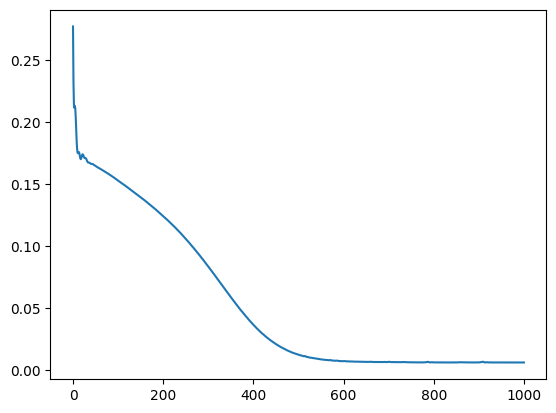

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses);

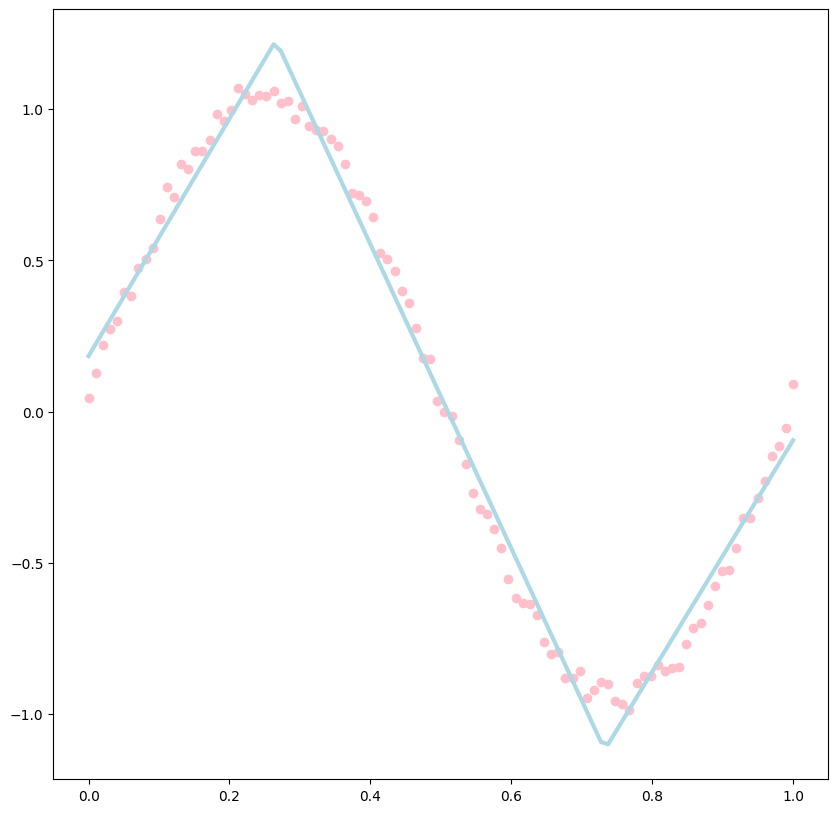

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.scatter(X.numpy(), y.numpy(), color = "pink")
axs.plot(X.numpy(), ys[-1].detach().numpy(), 'lightblue', lw=3)

## 3.3 Построение сетей при помощи `torch.nn`

In [ ]:
import torch.nn as nn
import torch
import numpy as np

3.3.1 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде класса - наследника `nn.Module`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim`

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
class Network(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(1, n_hidden_neurons)

        # поэкспериментировать с другиями функциями активации

        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

network = Network(50)

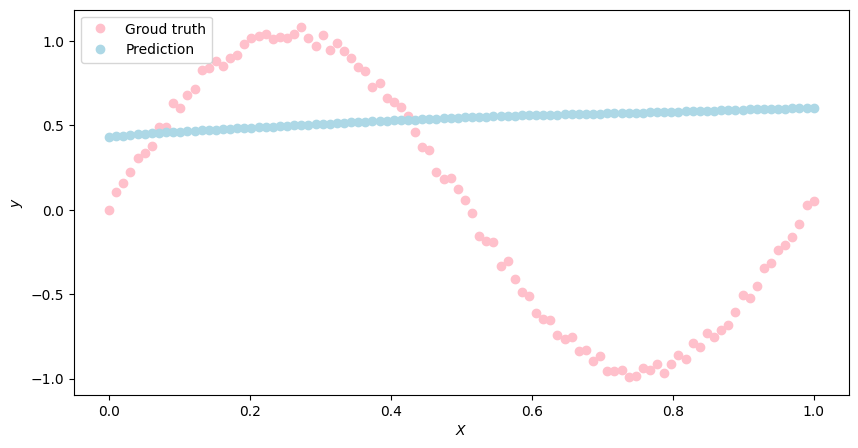

In [ ]:
import matplotlib.pyplot as plt

def predict(net, X, y):
        y_pred = net.forward(X)

        plt.figure(figsize=(10, 5))
        plt.plot(X.numpy(), y.numpy(), 'o', label='Groud truth', c='pink')
        plt.plot(X.numpy(), y_pred.data.numpy(), 'o', c='lightblue', label='Prediction');
        plt.legend(loc='upper left')
        plt.xlabel('$X$')
        plt.ylabel('$y$')

predict(network, X, y)

In [ ]:
optimizer = torch.optim.Adam(network.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

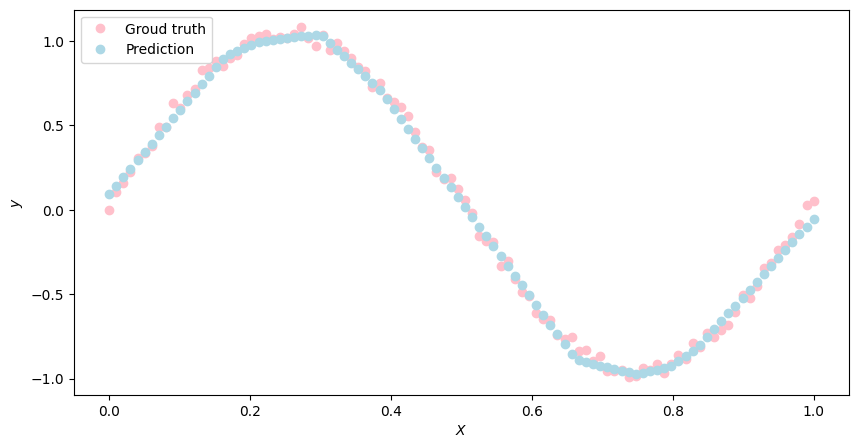

In [ ]:
for epoch_index in range(1001):
    optimizer.zero_grad()

    y_pred = network.forward(X)
    loss_val = criterion.forward(y_pred, y)

    loss_val.backward()

    optimizer.step()

predict(network, X, y)

3.3.2 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim`

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

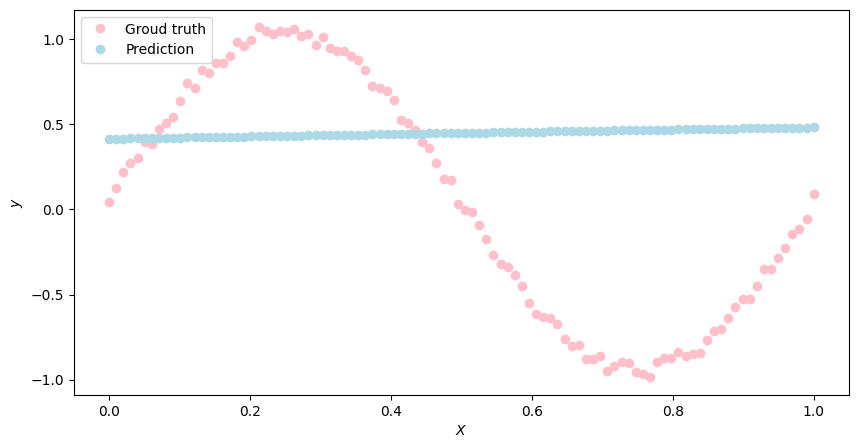

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 50),
    nn.Sigmoid(),
    nn.Linear(50,1)
)
predict(model, X, y)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

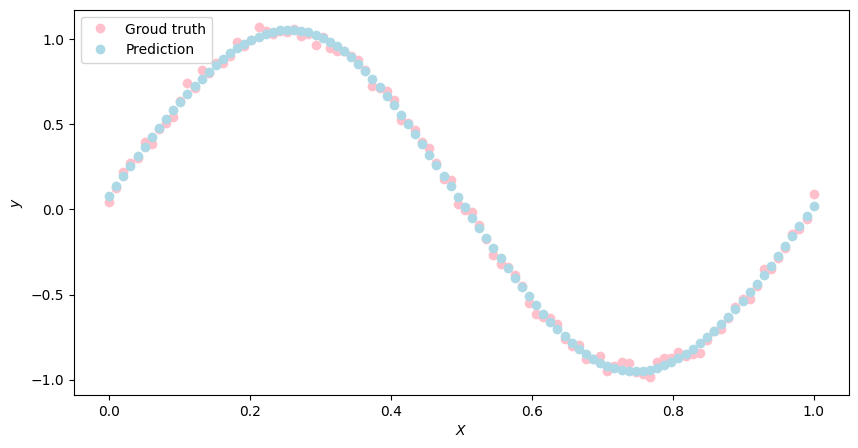

In [ ]:
for epoch_index in range(3000):
    optimizer.zero_grad()

    y_pred = model.forward(X)
    loss_val = criterion.forward(y_pred, y)

    loss_val.backward()

    optimizer.step()

predict(model, X, y)

## 3.4. Datasets and dataloaders

In [ ]:
from torch.utils.data import Dataset, DataLoader

3.4.1 Создать датасет, поставляющий данные из задачи 3.1.2.

Создать `DataLoader` на основе этого датасета и проверить работоспособность.

Воспользовавшись результатами 3.3.1 (или 3.3.2) обучите модель, пользуясь мини-пакетным градиентным спуском с размером пакета (`batch_size`) = 10

In [ ]:
class SinDataset(Dataset):
    def __init__(self):
        self.n_samples = X.shape[0]
        self.X = X
        self.y = y

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

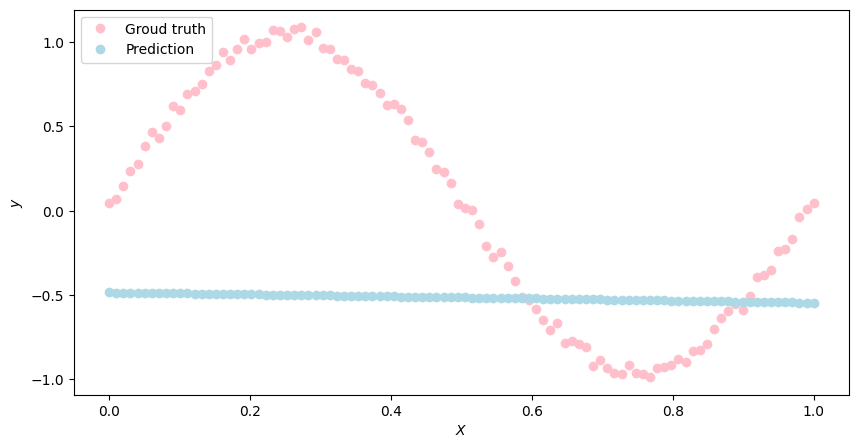

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 50),
    nn.Sigmoid(),
    nn.Linear(50,1)
)
dataset = SinDataset()
dataloader = DataLoader(dataset, batch_size=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')
predict(model, X, y)

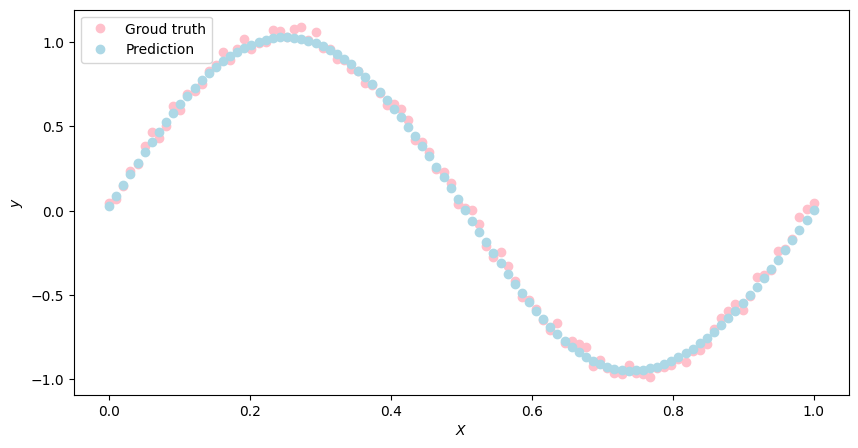

In [ ]:
n_epoch = 1000
for epoch in range(n_epoch):
    for x_example, y_example in dataloader:
        optimizer.zero_grad()

        y_pred = model.forward(x_example)
        loss_val = criterion.forward(y_pred, y_example)

        loss_val.backward()

        optimizer.step()

predict(model, X, y)

3.4.2 Предсказание цен алмазов

3.4.2.1 Создайте датасет на основе файла diamonds.csv.

1. Удалите все нечисловые столбцы
2. Целевой столбец (`y`) - `price`
3. Преобразуйте данные в тензоры корректных размеров

3.4.2.2 Разбейте датасет на обучающий и тестовый датасет при помощи `torch.utils.data.random_split`.

3.4.2.3 Обучите модель для предсказания цен при помощи мини-пакетного градиентного спуска (`batch_size = 256`).

3.4.2.4 Выведите график функции потерь в зависимости от номера эпохи (значение потерь для эпохи рассчитывайте как среднее значение ошибок на каждом батче). Проверьте качество модели на тестовой выборке.

In [ ]:
import pandas as pd

diamonds = pd.read_csv('diamonds.csv', index_col=0)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
diamonds.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [ ]:
class PandasDataset(Dataset):
    def __init__(self, data):
        data = diamonds.select_dtypes(include=np.number)
        self.data_x = torch.from_numpy(data.drop("price", axis=1).values).float()
        self.data_y = torch.from_numpy(data[["price"]].values).float()
        self.n_samples = self.data_x.shape[0]


    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.data_x[idx], self.data_y[idx]

In [ ]:
data = PandasDataset(diamonds)
train, test = torch.utils.data.random_split(data, [0.8, 0.2])

In [ ]:
dataloader = DataLoader(dataset=train, batch_size=256)

model = nn.Sequential(
    nn.BatchNorm1d(X.shape[-1]),
    nn.Linear(X.shape[-1], 100),
    nn.Softmax(),
    nn.Linear(100, 100),
    nn.Softmax(),
    nn.Linear(100,1)
)

In [ ]:
lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction='sum')

losses_all = []
n_epoch = 301
for epoch in range(n_epoch):
    losses = torch.empty(0)
    for step, (x_example, y_example) in enumerate(dataloader):
        y_pred = model(x_example)
        loss = criterion(y_pred, y_example)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = torch.cat((losses, loss.view(1)))

    if epoch % 25 == 0:
        print('epoch', epoch, 'loss', losses.mean().item())
    losses_all.append(losses.mean().item())

epoch 0 loss 4035683328.0
epoch 25 loss 3981312000.0
epoch 50 loss 3948381696.0
epoch 75 loss 3930291200.0
epoch 100 loss 3921796608.0
epoch 125 loss 3918567424.0
epoch 150 loss 3917583872.0
epoch 175 loss 3917332736.0
epoch 200 loss 3917274880.0
epoch 225 loss 3917262080.0
epoch 250 loss 3917259776.0
epoch 275 loss 3917258496.0
epoch 300 loss 3917258240.0


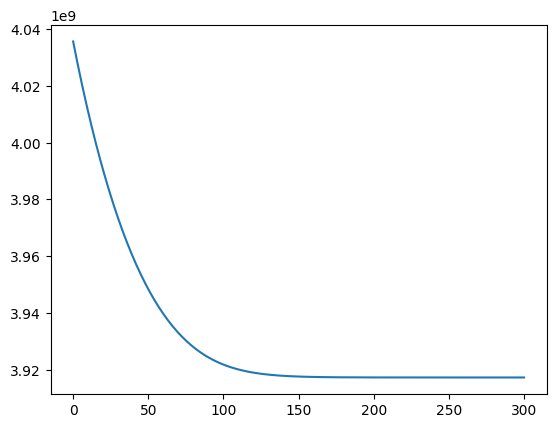

In [ ]:
plt.plot(losses_all);

In [ ]:
dataloader = DataLoader(dataset=test, batch_size=256)
losses = torch.empty(0)
for x_example, y_example in dataloader:
    y_pred = model(x_example)
    loss = criterion(y_pred, y_example)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses = torch.cat((losses, loss.view(1)))

print(losses.mean().item())

3917258496.0


In [ ]:
dataset.__getitem__(5)

(tensor([0.0505]), tensor([0.3828]))

###3.4.3 Модифицируйте метод `__init__` датасета из 3.4.2 таким образом, чтобы он мог принимать параметр `transform: callable`. Реализуйте класс `DropColsTransform` для удаления нечисловых данных из массива. Реализуйте класс `ToTensorTransorm` для трансформации массива в тензор.

In [ ]:
class PandasDataset(Dataset):
    def __init__(self, data, transform):
        self.n_samples = data.shape[0]
        self.transform = transform
        self.x_data = data.drop("price", axis=1).values
        self.y_data = data[["price"]].values

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        sample = self.x_data[idx], self.y_data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
class DropColsTransform:
    def __init__(self, drop):
        self.drop = drop
    def __call__(self, sample):
      X, y = sample
      X = np.delete(X, self.drop, 0)
      return X, y

In [ ]:
class ToTensorTransform:
    def __call__(self, sample):
        X, y = sample
        X = torch.from_numpy(X.astype("float")).float().view(-1)
        y = torch.from_numpy(y.astype("float")).float().view(-1)
        return X, y

In [ ]:
from torchvision import transforms

drop = DropColsTransform(drop=[1, 2, 3])
to_tensor = ToTensorTransform()
dataset = PandasDataset(diamonds, transforms.Compose([drop, to_tensor]))

In [ ]:
train, test = torch.utils.data.random_split(dataset, [0.8, 0.2])
dataloader = DataLoader(dataset=train, batch_size=256)

model = nn.Sequential(
    nn.BatchNorm1d(6),
    nn.Linear(6, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100,1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

epoch 0 loss 2209512448.0
epoch 25 loss 564266816.0
epoch 50 loss 560356544.0
epoch 75 loss 552169920.0
epoch 100 loss 529540416.0


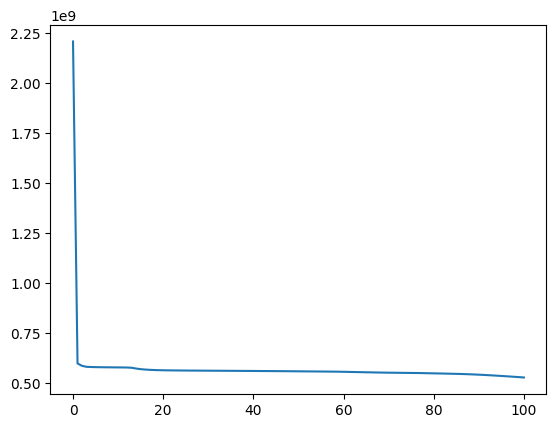

In [ ]:
losses_all = []
for epoch in range(101):
    losses = torch.empty(0)

    for x_example, y_example in dataloader:
        y_pred = model(x_example)
        loss = criterion(y_pred, y_example)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = torch.cat((losses, loss.view(1)))



    if epoch % 25 == 0:
        print('epoch', epoch, 'loss', losses.mean().item())
    losses_all.append(losses.mean().item())
plt.plot(losses_all);

In [ ]:
dataloader = DataLoader(dataset=test, batch_size=256)
losses = torch.empty(0)
for x_example, y_example in dataloader:
    y_pred = model(x_example)
    loss = criterion(y_pred, y_example)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses = torch.cat((losses, loss.view(1)))

print(losses.mean().item())

489632736.0
